In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sqlalchemy import create_engine
import json

#### Configuración de tema matplotlib

In [188]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
# https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle
pd.set_option('display.max_columns', None)

#### Conexión a base de datos

In [189]:
with open('../config/lyft_conection.json', 'r') as file:
    credenciales_lyft = json.load(file)

engine = create_engine(f"mysql+pymysql://{credenciales_lyft['USERNAME']}:{credenciales_lyft['PASSWORD']}@{credenciales_lyft['SERVER']}/{credenciales_lyft['DATABASE']}",
                       connect_args={
                            'init_command': "SET SESSION net_read_timeout=600, net_write_timeout=600, max_execution_time=3000000"
                        })

### Consultas a base de datos

In [190]:
start_date = '2024-12-01 00:00:00'
end_date = '2025-10-31 23:59:59'

In [191]:
sql_BikePaymentFact = f'''

SELECT
    bpf.id AS id_pago,
    bpf.bikeAccountNumber AS numero_cuenta,
    bpf.cardBin AS bin_tarjeta,
    bpf.merchantTxId AS id_transaccion,
    bpf.creationDateTime AS fecha_creacion,
    bpf.amount AS monto,
    -- Cruces --
    bst.name_localizedValue0 as tipo_membresia,
    prd.localizedValue0 AS resultado_pago,
    prrd.localizedValue0 AS rason_resultado_pago,
    pmd.localizedValue0 AS modo_pago
FROM BikePaymentFact bpf
JOIN BikeSubscriptionFact bs ON bpf.bikeAccountNumber = bs.member_accountNumber
JOIN BikeSubscriptionTypeDim bst ON bs.subscriptionType_id = bst.id
LEFT JOIN PaymentResultDim prd ON bpf.paymentResult_id = prd.id
LEFT JOIN PaymentResultReasonDim prrd ON bpf.paymentResultReason_id = prrd.id
LEFT JOIN PaymentModeDim pmd ON bpf.paymentMode_id = pmd.id
WHERE 
	creationDateTime BETWEEN UNIX_TIMESTAMP(CONVERT_TZ("{start_date}", "America/Mexico_City", 'UTC'))*1000
    AND UNIX_TIMESTAMP(CONVERT_TZ("{end_date}", "America/Mexico_City", 'UTC'))*1000;

'''

df_sql_BikePaymentFact = pd.read_sql(sql_BikePaymentFact, engine)
df_sql_BikePaymentFact.head(2)

,id_pago,numero_cuenta,bin_tarjeta,id_transaccion,fecha_creacion,monto,tipo_membresia,resultado_pago,rason_resultado_pago,modo_pago
0,6638652,586211,407561.0,cyb_cnp0006637917,1733061604677,5450000,Migrated Membership,Refused,None,Credit card
1,6638525,467111,474124.0,cyb_cnp0006637790,1733040006341,0,Migrated Membership,Accepted,None,Credit card


In [223]:
df_sql_BikePaymentFact.size

23439740

##### Agregar BINES

In [192]:
# importar CSV
csv_file_path = '../data/Bin_ECOBICI.csv'
df_bines = pd.read_csv(csv_file_path, encoding='utf-8')
df_bines.head(1)

,BIN,LONGITUD,RANGO,ID INSTITUCIÃN,INSTITUCIÃN,PRODUCTO,NOMBRE CORTO,NATURALEZA,MARCA
0,202022,6,COMPLETO,110030,BAJIO,PRESTAMOS ABCD,ABCD,CRÃDITO,PRIVADA


In [193]:
# Agregar datos de df_bines a df_sql_BikePaymentFact
df_main = pd.merge(df_sql_BikePaymentFact, df_bines, how='left', left_on='bin_tarjeta', right_on='BIN')
df_main.head(1)

,id_pago,numero_cuenta,bin_tarjeta,id_transaccion,fecha_creacion,monto,tipo_membresia,resultado_pago,rason_resultado_pago,modo_pago,BIN,LONGITUD,RANGO,ID INSTITUCIÃN,INSTITUCIÃN,PRODUCTO,NOMBRE CORTO,NATURALEZA,MARCA
0,6638652,586211,407561.0,cyb_cnp0006637917,1733061604677,5450000,Migrated Membership,Refused,None,Credit card,407561.0,6.0,COMPLETO,116055.0,TARJETAS DEL FUTURO,RAPPICARD CLÃSICA,RAPPICARD,CRÃDITO,VISA


In [194]:
# borrar columnas innecesarias BIN	LONGITUD	RANGO	ID INSTITUCIÃN
df_main = df_main.drop(columns=['BIN', 'LONGITUD', 'RANGO', 'ID INSTITUCIÃN', 'PRODUCTO', 'NOMBRE CORTO'])
df_main.head(1)

,id_pago,numero_cuenta,bin_tarjeta,id_transaccion,fecha_creacion,monto,tipo_membresia,resultado_pago,rason_resultado_pago,modo_pago,INSTITUCIÃN,NATURALEZA,MARCA
0,6638652,586211,407561.0,cyb_cnp0006637917,1733061604677,5450000,Migrated Membership,Refused,None,Credit card,TARJETAS DEL FUTURO,CRÃDITO,VISA


In [195]:
# renombrar columnas INSTITUCIÃN NATURALEZA MARCA
df_main = df_main.rename(columns={
    'INSTITUCIÃN': 'institucion',
    'NATURALEZA': 'naturaleza',
    'MARCA': 'marca'
})
df_main.head(1)

,id_pago,numero_cuenta,bin_tarjeta,id_transaccion,fecha_creacion,monto,tipo_membresia,resultado_pago,rason_resultado_pago,modo_pago,institucion,naturaleza,marca
0,6638652,586211,407561.0,cyb_cnp0006637917,1733061604677,5450000,Migrated Membership,Refused,None,Credit card,TARJETAS DEL FUTURO,CRÃDITO,VISA


In [196]:
# Formatos de fecha
df_main['fecha_creacion'] = pd.to_datetime(df_main['fecha_creacion'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('America/Mexico_City')
df_main.head(1)

,id_pago,numero_cuenta,bin_tarjeta,id_transaccion,fecha_creacion,monto,tipo_membresia,resultado_pago,rason_resultado_pago,modo_pago,institucion,naturaleza,marca
0,6638652,586211,407561.0,cyb_cnp0006637917,2024-12-01 08:00:04.677000-06:00,5450000,Migrated Membership,Refused,None,Credit card,TARJETAS DEL FUTURO,CRÃDITO,VISA


In [197]:
# coregir valores de naturaleza
df_main['naturaleza'] = df_main['naturaleza'].replace({'DÃBITO': 'DÉBITO', 'CRÃDITO': 'CRÉDITO'})

df_main['naturaleza'].value_counts()

naturaleza
DÉBITO     1157965
CRÉDITO    1081478
PREPAGO         68
Name: count, dtype: int64

#### Conexion a Cybersource

In [198]:
with open('../config/cybersource_conection.json', 'r') as file:
    credenciales = json.load(file)

In [199]:
connection_string = f"mssql+pyodbc://{credenciales['USERNAME']}:{credenciales['PASSWORD']}@{credenciales['SERVER']}/{credenciales['DATABASE']}?driver=ODBC+Driver+17+for+SQL+Server&timeout=30"
engine = create_engine(connection_string)

In [200]:
query = """
            SELECT
                MerchantReferenceNumber,
                AuthorizationCode,
                Status
            FROM dbo.Cybersource
            WHERE 
                BatchDate BETWEEN '2024-12-01 00:00:00' AND '2025-11-31 23:59:59'
                AND MerchantReferenceNumber NOT LIKE 'cybs_test%';
            """

df_ingresos = pd.read_sql(query, engine)
df_ingresos.head()

,MerchantReferenceNumber,AuthorizationCode,Status
0,cyb_cnp0006635720,078626,BATCHED
1,cyb_cnp0006635721,648012,BATCHED
2,cyb_cnp0006635722,075264,BATCHED
3,cyb_cnp0006635723,04667D,BATCHED
4,cyb_cnp0006635724,438052,BATCHED


In [201]:
df_ingresos['Status'].value_counts()

Status
BATCHED    499146
Name: count, dtype: int64

#### Data frame final

In [202]:
df_main.head()

,id_pago,numero_cuenta,bin_tarjeta,id_transaccion,fecha_creacion,monto,tipo_membresia,resultado_pago,rason_resultado_pago,modo_pago,institucion,naturaleza,marca
0,6638652,586211,407561.0,cyb_cnp0006637917,2024-12-01 08:00:04.677000-06:00,5450000,Migrated Membership,Refused,None,Credit card,TARJETAS DEL FUTURO,CRÉDITO,VISA
1,6638525,467111,474124.0,cyb_cnp0006637790,2024-12-01 02:00:06.341000-06:00,0,Migrated Membership,Accepted,None,Credit card,NaN,NaN,NaN
2,6638487,467111,474124.0,cyb_cnp0006637752,2024-12-01 01:29:44.223000-06:00,10000,Migrated Membership,Accepted,None,Credit card,NaN,NaN,NaN
3,6638190,328265,421316.0,cyb_cnp0006637455,2024-12-01 00:00:11.123000-06:00,4632600,Migrated Membership,Accepted,None,Credit card,HSBC,DÉBITO,VISA
4,6638655,601769,549138.0,cyb_cnp0006637920,2024-12-01 08:00:06.364000-06:00,5450000,Migrated Membership,Accepted,None,Credit card,BANAMEX,CRÉDITO,MASTER CARD


In [203]:

df_main['monto_final'] = df_main['monto'] / 10000
df_main.head(1)

,id_pago,numero_cuenta,bin_tarjeta,id_transaccion,fecha_creacion,monto,tipo_membresia,resultado_pago,rason_resultado_pago,modo_pago,institucion,naturaleza,marca,monto_final
0,6638652,586211,407561.0,cyb_cnp0006637917,2024-12-01 08:00:04.677000-06:00,5450000,Migrated Membership,Refused,None,Credit card,TARJETAS DEL FUTURO,CRÉDITO,VISA,545.0


In [204]:
# # extraer semana y año de la fecha_creacion
df_main['semana'] = df_main['fecha_creacion'].dt.isocalendar().week
df_main['año'] = df_main['fecha_creacion'].dt.year
# agregar columna semana_año
df_main['semana_año'] = df_main['año'].astype(str) + '-W' + df_main['semana'].astype(str)
df_main.head(1)

,id_pago,numero_cuenta,bin_tarjeta,id_transaccion,fecha_creacion,monto,tipo_membresia,resultado_pago,rason_resultado_pago,modo_pago,institucion,naturaleza,marca,monto_final,semana,año,semana_año
0,6638652,586211,407561.0,cyb_cnp0006637917,2024-12-01 08:00:04.677000-06:00,5450000,Migrated Membership,Refused,None,Credit card,TARJETAS DEL FUTURO,CRÉDITO,VISA,545.0,48,2024,2024-W48


### Analisis exploratorio de transacciones de Lyft

In [205]:

print('Número total de transacciones:', df_main.shape[0])

Número total de transacciones: 2550203


#### Desglose de Rechazos y Aceptaciones

- ¿Cuál es el porcentaje total de transacciones que fueron Rechazadas (resultado_pago) en comparación con las Aceptadas?

In [206]:
# - ¿Cuál es el porcentaje total de transacciones que fueron Rechazadas (resultado_pago) en comparación con las Aceptadas?
df_resultado_pago = df_main['resultado_pago'].value_counts(normalize=True) * 100
df_resultado_pago = df_resultado_pago.reset_index()
df_resultado_pago.columns = ['resultado_pago', 'porcentaje']
df_resultado_pago['porcentaje'] = df_resultado_pago['porcentaje'].round(2)
df_resultado_pago

,resultado_pago,porcentaje
0,Accepted,54.24
1,Refused,42.41
2,Error,3.35
3,Cancelled,0.01


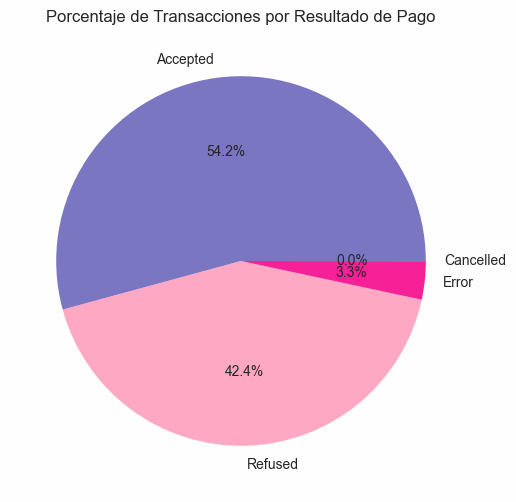

In [207]:
# graficar
plt.figure(figsize=(8, 6))
plt.pie(df_resultado_pago['porcentaje'], labels=df_resultado_pago['resultado_pago'], autopct='%1.1f%%')
plt.title('Porcentaje de Transacciones por Resultado de Pago')
plt.show()

In [208]:
# obtener totales en numeros
df_totales_numeros = df_main['resultado_pago'].value_counts()
df_totales_numeros

resultado_pago
Accepted     1383193
Refused      1081469
Error          85328
Cancelled        213
Name: count, dtype: int64

In [209]:
# filtrar por rechazos
df_rechazos = df_main[df_main['resultado_pago'] != 'Accepted']
df_aceptados = df_main[df_main['resultado_pago'] == 'Accepted']

# calcular tasa de rechazo
tasa_rechazo = (df_rechazos.shape[0] / df_main.shape[0]) * 100
print(f'Tasa de Rechazo: {tasa_rechazo:.2f}%')
tasa_aceptacion = (df_aceptados.shape[0] / df_main.shape[0]) * 100
print(f'Tasa de Aceptación: {tasa_aceptacion:.2f}%')

Tasa de Rechazo: 45.76%
Tasa de Aceptación: 54.24%


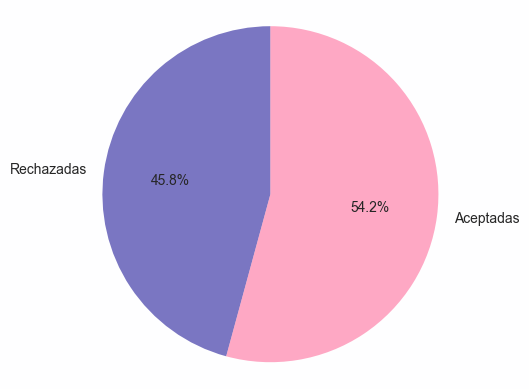

In [210]:
# graficar tasa de rechazo y aceptacion
labels = ['Rechazadas', 'Aceptadas']
sizes = [tasa_rechazo, tasa_aceptacion]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

In [211]:
print('Número total de transacciones:', df_rechazos.shape[0] + df_aceptados.shape[0])
print('Número total de transacciones rechazadas:', df_rechazos.shape[0])
print('Número total de transacciones aceptadas:', df_aceptados.shape[0])

Número total de transacciones: 2550203
Número total de transacciones rechazadas: 1167010
Número total de transacciones aceptadas: 1383193


- ¿Cuál es la distribución de los montos (monto) para las transacciones Rechazadas vs. las Aceptadas? ¿Hay una diferencia notable en el monto promedio?

In [212]:
df_rechazos = df_main[df_main['resultado_pago'] != 'Accepted']
df_aceptados = df_main[df_main['resultado_pago'] == 'Accepted']

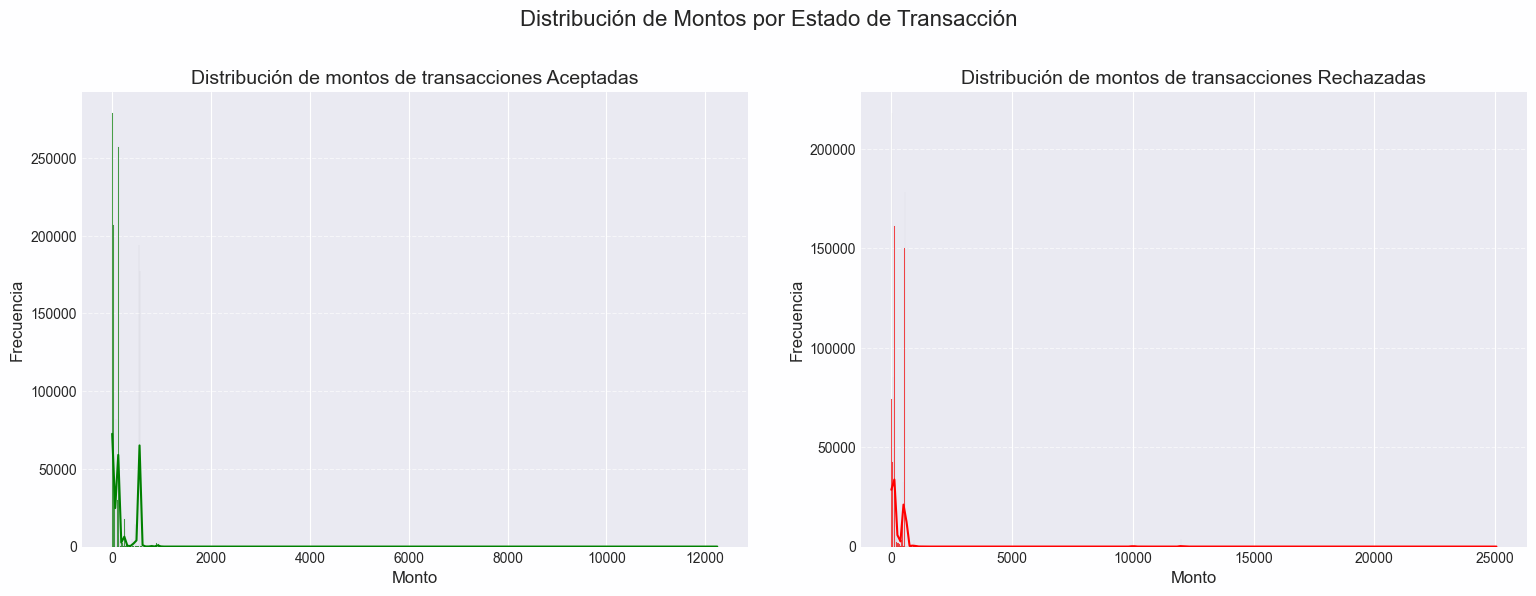

In [213]:
# El tamaño de la figura (figsize) se ajusta para que los gráficos sean legibles.
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# 'axes' ahora es un array que contiene los dos ejes: axes[0] y axes[1].

# --- Gráfico 1: Transacciones Aceptadas ---
sns.histplot(
    df_aceptados['monto_final'],
    kde=True,
    ax=axes[0],  # Indicamos que este gráfico va en el primer eje
    color='green',
    alpha=0.7
)
axes[0].set_title('Distribución de montos de transacciones Aceptadas', fontsize=14)
axes[0].set_xlabel('Monto', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.6)


# --- Gráfico 2: Transacciones Rechazadas ---
sns.histplot(
    df_rechazos['monto_final'],
    kde=True,
    ax=axes[1],  # Indicamos que este gráfico va en el segundo eje
    color='red',
    alpha=0.7
)
axes[1].set_title('Distribución de montos de transacciones Rechazadas', fontsize=14)
axes[1].set_xlabel('Monto', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.6)


# Ajustamos los espacios entre subplots para evitar superposiciones
plt.tight_layout(pad=3.0)

# Opcional: Título general para toda la figura
fig.suptitle('Distribución de Montos por Estado de Transacción', fontsize=16, y=1.03)

plt.show()

C:\Users\victor.briones\AppData\Local\Temp\ipykernel_19340\1928170759.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=['Rechazadas', 'Aceptadas'], patch_artist=True)


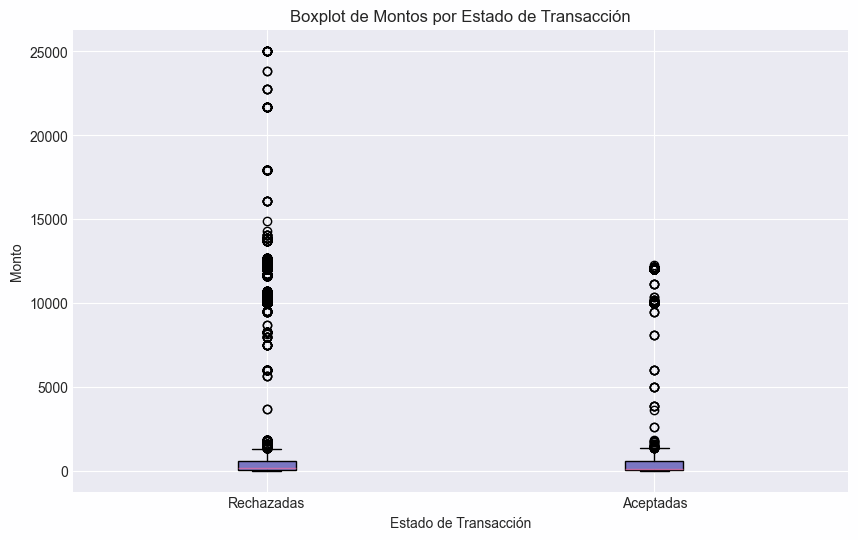

In [214]:
 # Boxplot unido de montos rechazados y aceptados
plt.figure(figsize=(10, 6))
data_to_plot = [df_rechazos['monto_final'], df_aceptados['monto_final']]
plt.boxplot(data_to_plot, labels=['Rechazadas', 'Aceptadas'], patch_artist=True)
plt.title('Boxplot de Montos por Estado de Transacción')
plt.xlabel('Estado de Transacción')
plt.ylabel('Monto')
plt.show()

In [215]:
print("----- Estadísticas descriptivas de montos rechazados -----")
print(df_rechazos['monto_final'].describe().round(2))
print("----- Estadísticas descriptivas de montos aceptados -----")
print(df_aceptados['monto_final'].describe().round(2))

----- Estadísticas descriptivas de montos rechazados -----
count    1167010.00
mean         329.02
std          972.54
min            0.00
25%           27.00
50%          127.99
75%          545.00
max        25049.96
Name: monto_final, dtype: float64
----- Estadísticas descriptivas de montos aceptados -----
count    1383193.00
mean         218.97
std          301.30
min            0.00
25%           26.00
50%          122.99
75%          545.00
max        12243.02
Name: monto_final, dtype: float64


- ¿Qué razón de rechazo (rason) es la más común? (Aunque en el ejemplo todas son 'None', es vital explorar esta columna por si hubiera datos útiles).

In [216]:
df_main['rason_resultado_pago'].value_counts()

rason_resultado_pago
None                              2171698
Suspected fraud (Sift Science)     286410
Processing error                    85328
BIN validation failed                6471
Payment too slow                      213
Invalid billing informations           83
Name: count, dtype: int64

In [217]:
# agrupar por rason_resultado_pago y resultado_pago
df_razon_resultado = df_main.groupby(['rason_resultado_pago', 'resultado_pago']).size().reset_index(name='conteo')
df_razon_resultado.sort_values(by='conteo', ascending=False)

,rason_resultado_pago,resultado_pago,conteo
2,None,Accepted,1383193
3,None,Refused,788505
6,Suspected fraud (Sift Science),Refused,286410
5,Processing error,Error,85328
0,BIN validation failed,Refused,6471
4,Payment too slow,Cancelled,213
1,Invalid billing informations,Refused,83


In [218]:
# filtrar las transacciones que no sean aceptadas
df_rechazos = df_main[df_main['resultado_pago'] != 'Accepted']
df_rechazos.head(2)

,id_pago,numero_cuenta,bin_tarjeta,id_transaccion,fecha_creacion,monto,tipo_membresia,resultado_pago,rason_resultado_pago,modo_pago,institucion,naturaleza,marca,monto_final,semana,año,semana_año
0,6638652,586211,407561.0,cyb_cnp0006637917,2024-12-01 08:00:04.677000-06:00,5450000,Migrated Membership,Refused,None,Credit card,TARJETAS DEL FUTURO,CRÉDITO,VISA,545.0,48,2024,2024-W48
8,6638481,415954,415231.0,cyb_cnp0006637746,2024-12-01 01:13:01.959000-06:00,10000,Migrated Membership,Refused,None,Credit card,BBVA,DÉBITO,VISA,1.0,48,2024,2024-W48


In [222]:
# agrupar por rason_resultado_pago y contar
df_razon_rechazos = df_rechazos['rason_resultado_pago'].value_counts().reset_index()
df_razon_rechazos.columns = ['rason_resultado_pago', 'conteo']
df_razon_rechazos

,rason_resultado_pago,conteo
0,None,788505
1,Suspected fraud (Sift Science),286410
2,Processing error,85328
3,BIN validation failed,6471
4,Payment too slow,213
5,Invalid billing informations,83



#### Análisis Temporal y de Frecuencia

- ¿Existe alguna hora del día o día de la semana (fecha_creacion) en la que los rechazos son significativamente más altos?
- ¿Hay cuentas (numero_cuenta) que presenten una tasa de rechazo desproporcionadamente alta? ¿Son cuentas nuevas o antiguas?
- ¿Cómo se distribuyen los rechazos por tipo de membresía (tipo_membresia)?

#### Impacto de las Tarjetas y Bancos

- ¿Cuál es la tasa de rechazo por Marca de Tarjeta (marca) (e.g., VISA, Mastercard, etc.)?
- ¿Cuál es la tasa de rechazo por Institución Bancaria (institucion)? ¿Hay bancos específicos con tasas de rechazo notablemente altas o bajas?
- ¿Existe una diferencia significativa en la tasa de rechazo entre tarjetas de Crédito y Débito (naturaleza)?

#### 